In [13]:
import numpy as np 
import pandas as pd 
import torch # for models
from torch import nn
import torchvision
from torchvision import transforms, datasets
import pathlib
from torchvision.datasets import ImageFolder
import torch.nn.functional as F
import torchmetrics
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset, Dataset
from sklearn.model_selection import train_test_split
from PIL import Image
import gc
import os
import random
from torch.autograd import Variable
import matplotlib.pyplot as plt
from tqdm import tqdm
import collections
torch.manual_seed(42)

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [3]:
class CNN(nn.Module):
    def __init__(self,number_of_classes):
        super().__init__() #Inheritance
        self.conv1 = nn.Conv2d(in_channels=3,out_channels=16,padding=1,kernel_size=3)
        self.bn1=nn.BatchNorm2d(num_features=16)
        self.relu1=nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=3)
        self.fc=nn.Linear(in_features=87616, out_features=number_of_classes)
    
    def forward(self, input):            
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        output=self.pool1(output)
        output = torch.flatten(output, 1)
        output = self.fc(output)
        return output

In [4]:
# preprocessing
preprocess = transforms.Compose([
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

path = pathlib.Path("data/Rice_Image_Dataset")
dataset = datasets.ImageFolder(path, transform=preprocess)

# dataset loader
BATCH_SIZE = 256

# Number of classes
NUM_CLASSES = 5

# train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(dataset, (0.7, 0.2, 0.1))
# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
# valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=True)
# test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
# Get the target values (labels) from the dataset
targets = np.array(dataset.targets)

val_prop = 0.2
test_prop = 0.1

# Split the dataset into train and test sets
train_val_indices, test_indices, train_val_targets, test_targets = train_test_split(np.arange(len(dataset)), targets, test_size=test_prop, stratify=targets)

# Split the train set into train and validation sets
train_indices, val_indices, train_targets, val_targets = train_test_split(train_val_indices, train_val_targets, test_size=val_prop, stratify=train_val_targets)

# Create custom PyTorch datasets for the train, validation, and test sets using the original dataset and the indices of the split data
train_dataset = Subset(dataset, train_indices)
val_dataset = Subset(dataset, val_indices)
test_dataset = Subset(dataset, test_indices)

# Create custom dataloaders for the train, validation, and test sets
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# Create custom dataloaders for one/few shot learning
class OneShotDataset(Dataset):
    def __init__(self, path, num_classes=5, transform=preprocess):
        self.path = path
        self.num_classes = num_classes
        self.transform = transform
        self.dataset = datasets.ImageFolder(root=path, transform=transform)
        self.indices = self._get_one_shot_indices()
        
    def _get_one_shot_indices(self):
        indices = [[] for _ in range(self.num_classes)]
        for idx, (image, label) in enumerate(self.dataset):
            indices[label].append(idx)
        return indices
    
    def __len__(self):
        return self.num_classes
    
    def __getitem__(self, idx):
        batch = []
        labels = []
        for class_idx in range(self.num_classes):
            sample_idx = random.choice(self.indices[class_idx])
            sample, label = self.dataset[sample_idx]
            batch.append(sample)
            labels.append(label)
        batch = torch.stack(batch, dim=0)
        labels = torch.LongTensor(labels)
        return batch, labels

one_shot_dataset = OneShotDataset("data/Rice_Image_Dataset/")

train_dataloader_1 = DataLoader(one_shot_dataset, batch_size=1, shuffle=False)

In [17]:
torch.equal(batch, batch2)

False

In [16]:
batch, labels = next(iter(train_dataloader_1))
print(f"Batch 1 has unique labels: {labels.unique().tolist()}")

Batch 1 has unique labels: [0, 1, 2, 3, 4]


In [6]:
def train_model_shots(model, shots=1, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, lr=1e-3, momentum=0.9, num_classes=5, epochs=1):
    # one/few shot learning
    for param in model.parameters():
        param.requires_grad = False
        
    if hasattr(model, 'fc'):
        model.fc = nn.Linear(model.fc.in_features, num_classes).to(device)
        optimizer = torch.optim.SGD([
            {'params': model.fc.parameters()}
        ], lr=lr, momentum=momentum)
    elif hasattr(model, 'classifier'):
        in_features = model.classifier[-1].in_features
        model.classifier[-1] = nn.Linear(in_features, num_classes).to(device)
        optimizer = torch.optim.SGD([
            {'params': model.classifier[-1].parameters()}
        ], lr=lr, momentum=momentum)
    else:
        raise ValueError('Model has no fc or classifier attribute')
        
    model.train()
    
    counter = 0
    for inputs, targets in train_dataloader:
        targets = targets#.squeeze(0)
        inputs = inputs#.squeeze(0)
        counter += 1
        inputs = inputs.to(device)
        targets = targets.to(device)
        
        for epoch in range(epochs):
            train_loss = 0.0
            train_acc = 0.0
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = torch.nn.functional.cross_entropy(outputs, targets)
            train_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            train_acc += torch.sum(predictions == targets.data)
            # Backward pass
            loss.backward()
            optimizer.step()

            train_loss /= 5
            train_acc /= 5
            val_acc, val_loss = get_acc(model=model, dataloader=val_dataloader, num_classes=num_classes)
            print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
                    .format(epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))

        if counter == shots:
            break

        

    return model


def train_model(model, train_dataloader=train_dataloader, val_dataloader=val_dataloader, device=device, lr=1e-3, momentum=0.9, num_classes=5, epochs=1):
    train_acc_lst = []
    val_acc_lst = []
    train_loss_lst = []
    val_loss_lst = []
    # Freeze the weights of the model
    for param in model.parameters():
        param.requires_grad = False
    try:
        model_in_features = model.fc.in_features
        model.fc = torch.nn.Linear(model_in_features, num_classes).to(device)
        optimizer = torch.optim.SGD([
                        {'params': model.fc.parameters()}
                    ],
                    lr=lr,
                    momentum=momentum
                )
    except:
        model_in_features = model.classifier[-1].in_features
        model.classifier[-1] = torch.nn.Linear(model_in_features, num_classes).to(device)
        optimizer = torch.optim.SGD([
                            {'params': model.classifier[-1].parameters()}
                        ],
                        lr=lr,
                        momentum=momentum
                    )
    model.train()
    for epoch in range(epochs):
        print(f'running epoch {epoch+1}')
        train_loss = 0.0
        train_acc = 0.0
        for inputs, targets in train_dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            # Zero the gradients
            optimizer.zero_grad()
            # Forward pass
            outputs = model(inputs)
            loss = torch.nn.functional.cross_entropy(outputs, targets)
            train_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            train_acc += torch.sum(predictions == targets.data)
            # Backward pass
            loss.backward()
            optimizer.step()

        train_loss /= len(train_dataloader.dataset)
        train_acc /= len(train_dataloader.dataset)
        val_acc, val_loss = get_acc(model=model, dataloader=val_dataloader, num_classes=num_classes)
        print('Epoch [{}/{}], Train Loss: {:.4f}, Train Acc: {:.4f}, Val Loss: {:.4f}, Val Acc: {:.4f}'
              .format(epoch+1, epochs, train_loss, train_acc, val_loss, val_acc))
        train_acc_lst.append(train_acc)
        val_acc_lst.append(val_acc)
        train_loss_lst.append(train_loss)
        val_loss_lst.append(val_loss)
    training_metrics_result = {
        'train_acc': train_acc_lst,
        'val_acc': val_acc_lst,
        'train_loss': train_loss_lst,
        'val_loss': val_loss_lst
    }
    return model

def get_model_specs(model):
    total_params = 0 #default value
    total_params = sum(
        param.numel() for param in model.parameters()
    )
    return total_params

def evaluate_model(model, train_dataloader, val_dataloader, test_dataloader, num_classes=5):
    print('collecting param count')
    total_params = get_model_specs(model)
    print('collecting train accuracy')
    train_acc, train_loss = get_acc(model=model, dataloader=train_dataloader, num_classes=num_classes)
    print('collecting validation accuracy')
    val_acc, val_loss = get_acc(model=model, dataloader=val_dataloader, num_classes=num_classes)
    print('collecting test accuracy')
    test_acc, test_loss = get_acc(model=model, dataloader=test_dataloader, num_classes=num_classes)
    metrics_dict = {
        'total_params': total_params,
        'train_acc': train_acc,
        'train_loss': train_loss,
        'val_acc': val_acc,
        'val_loss': val_loss,
        'test_acc': test_acc,
        'test_loss': test_loss
    }
    metrics_idx = list(metrics_dict.keys())
    metrics = pd.Series(data=metrics_dict, index=metrics_idx)
    return metrics

def get_acc(model, dataloader, num_classes):
    model.eval()
    predictions = []
    targets = []
    total_loss = 0.0
    total_samples = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            # Move the inputs and labels to the device
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Forward pass
            outputs = model(inputs)
            preds = F.softmax(outputs, dim=1)

            # Calculate the loss
            loss = torch.nn.functional.cross_entropy(outputs, labels)
            total_loss += loss.item() * inputs.size(0)
            total_samples += inputs.size(0)

            # Store the predictions and targets
            predictions.extend(preds.cpu().detach().numpy())
            targets.extend(labels.cpu().detach().numpy())

    # Calculate the accuracy and average loss
    accuracy = torchmetrics.functional.accuracy(torch.tensor(predictions), torch.tensor(targets), num_classes=num_classes, task='multiclass')
    avg_loss = total_loss / total_samples
    
    return accuracy, avg_loss

In [7]:
# model loading
not_pretrained_resnet_model = torchvision.models.resnet34(pretrained=False).to(device)
not_pretrained_alexnet_model = torchvision.models.alexnet(pretrained=False).to(device)
not_pretrained_vgg_model = torchvision.models.vgg16(pretrained=False).to(device)
pretrained_resnet_model = torchvision.models.resnet34(pretrained=True).to(device)
pretrained_alexnet_model = torchvision.models.alexnet(pretrained=True).to(device)
pretrained_vgg_model = torchvision.models.vgg16(pretrained=True).to(device)
not_pretrained_cnn_model = CNN(5).to(device)

# model training
print('training not pretrained resnet model')
not_pretrained_vgg_model_trained_one_shot = train_model_shots(not_pretrained_vgg_model, shots=1, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
print('training not pretrained alexnet model')
not_pretrained_alexnet_model_trained_one_shot = train_model_shots(not_pretrained_alexnet_model, shots=1, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
print('training not pretrained resnet model')
not_pretrained_resnet_model_trained_one_shot = train_model_shots(not_pretrained_resnet_model, shots=1, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
print('training pretrained resnet model')
pretrained_resnet_model_trained_one_shot = train_model_shots(pretrained_resnet_model, shots=1, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
print('training pretrained alexnet model')
pretrained_alexnet_model_trained_one_shot = train_model_shots(pretrained_alexnet_model, shots=1, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
print('training pretrained vgg model')
pretrained_vgg_model_trained_one_shot = train_model_shots(pretrained_vgg_model, shots=1, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
print('training not pretrained cnn model')
not_pretrained_cnn_model_trained_one_shot = train_model_shots(not_pretrained_cnn_model, shots=1, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)

# metrics_not_pretrained_vgg_model_one_shot = evaluate_model(not_pretrained_vgg_model_trained_one_shot, train_dataloader, val_dataloader, test_dataloader, 5)
# metrics_not_pretrained_alexnet_model_one_shot = evaluate_model(not_pretrained_alexnet_model_trained_one_shot, train_dataloader, val_dataloader, test_dataloader, 5)
# metrics_not_pretrained_resnet_model_one_shot = evaluate_model(not_pretrained_resnet_model_trained_one_shot, train_dataloader, val_dataloader, test_dataloader, 5)
# metrics_pretrained_resnet_model_one_shot = evaluate_model(pretrained_resnet_model_trained_one_shot, train_dataloader, val_dataloader, test_dataloader, 5)
# metrics_pretrained_alexnet_model_one_shot = evaluate_model(pretrained_alexnet_model_trained_one_shot, train_dataloader, val_dataloader, test_dataloader, 5)
# metrics_pretrained_vgg_model_one_shot = evaluate_model(pretrained_vgg_model_trained_one_shot, train_dataloader, val_dataloader, test_dataloader, 5)
# metrics_not_pretrained_cnn_model_one_shot = evaluate_model(not_pretrained_cnn_model_trained_one_shot, train_dataloader, val_dataloader, test_dataloader, 5)

# # print metrics
# print("Not pretrained VGG model trained one shot")
# print(metrics_not_pretrained_vgg_model_one_shot)
# print("Not pretrained Alexnet model trained one shot")
# print(metrics_not_pretrained_alexnet_model_one_shot)
# print("Not pretrained Resnet model trained one shot")
# print(metrics_not_pretrained_resnet_model_one_shot)
# print("Pretrained Resnet model trained one shot")
# print(metrics_pretrained_resnet_model_one_shot)
# print("Pretrained Alexnet model trained one shot")
# print(metrics_pretrained_alexnet_model_one_shot)
# print("Pretrained VGG model trained one shot")
# print(metrics_pretrained_vgg_model_one_shot)
# print("Not pretrained CNN model trained one shot")
# print(metrics_not_pretrained_cnn_model_one_shot)

/home/disheng/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/disheng/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
/home/disheng/.local/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/disheng/.local/lib/python3.10/site-packages/torchvis

training not pretrained resnet model
tensor([0, 1, 2, 3, 4])


/tmp/ipykernel_504/724179154.py:160: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  accuracy = torchmetrics.functional.accuracy(torch.tensor(predictions), torch.tensor(targets), num_classes=num_classes, task='multiclass')


Epoch [1/10], Train Loss: 1.6168, Train Acc: 0.0000, Val Loss: 1.6092, Val Acc: 0.2674
tensor([0, 1, 2, 3, 4])
Epoch [2/10], Train Loss: 1.6094, Train Acc: 0.2000, Val Loss: 1.6092, Val Acc: 0.2714
tensor([0, 1, 2, 3, 4])
Epoch [3/10], Train Loss: 1.6060, Train Acc: 0.4000, Val Loss: 1.6091, Val Acc: 0.2750
tensor([0, 1, 2, 3, 4])
Epoch [4/10], Train Loss: 1.6078, Train Acc: 0.2000, Val Loss: 1.6091, Val Acc: 0.2764
tensor([0, 1, 2, 3, 4])
Epoch [5/10], Train Loss: 1.6089, Train Acc: 0.2000, Val Loss: 1.6090, Val Acc: 0.2736
tensor([0, 1, 2, 3, 4])
Epoch [6/10], Train Loss: 1.6088, Train Acc: 0.2000, Val Loss: 1.6090, Val Acc: 0.2725
tensor([0, 1, 2, 3, 4])
Epoch [7/10], Train Loss: 1.6104, Train Acc: 0.2000, Val Loss: 1.6089, Val Acc: 0.2651
tensor([0, 1, 2, 3, 4])
Epoch [8/10], Train Loss: 1.6106, Train Acc: 0.2000, Val Loss: 1.6088, Val Acc: 0.2541
tensor([0, 1, 2, 3, 4])
Epoch [9/10], Train Loss: 1.6125, Train Acc: 0.2000, Val Loss: 1.6088, Val Acc: 0.2337
tensor([0, 1, 2, 3, 4])
E

In [ ]:
# model loading
not_pretrained_resnet_model = torchvision.models.resnet34(pretrained=False).to(device)
not_pretrained_alexnet_model = torchvision.models.alexnet(pretrained=False).to(device)
not_pretrained_vgg_model = torchvision.models.vgg16(pretrained=False).to(device)
pretrained_resnet_model = torchvision.models.resnet34(pretrained=True).to(device)
pretrained_alexnet_model = torchvision.models.alexnet(pretrained=True).to(device)
pretrained_vgg_model = torchvision.models.vgg16(pretrained=True).to(device)

# model training
not_pretrained_vgg_model_trained_five_shots = train_model_shots(not_pretrained_vgg_model, shots=5, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES)
not_pretrained_alexnet_model_trained_five_shots = train_model_shots(not_pretrained_alexnet_model, shots=5, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES)
not_pretrained_resnet_model_trained_five_shots = train_model_shots(not_pretrained_resnet_model, shots=5, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES)
pretrained_resnet_model_trained_five_shots = train_model_shots(pretrained_resnet_model, shots=5, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES)
pretrained_alexnet_model_trained_five_shots = train_model_shots(pretrained_alexnet_model, shots=5, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES)
pretrained_vgg_model_trained_five_shots = train_model_shots(pretrained_vgg_model, shots=5, train_dataloader=train_dataloader_1, val_dataloader=val_dataloader, device=device, num_classes=NUM_CLASSES)

metrics_not_pretrained_vgg_model_five_shots = evaluate_model(not_pretrained_vgg_model_trained_five_shots, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_not_pretrained_alexnet_model_five_shots = evaluate_model(not_pretrained_alexnet_model_trained_five_shots, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_not_pretrained_resnet_model_five_shots = evaluate_model(not_pretrained_resnet_model_trained_five_shots, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_pretrained_resnet_model_five_shots = evaluate_model(pretrained_resnet_model_trained_five_shots, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_pretrained_alexnet_model_five_shots = evaluate_model(pretrained_alexnet_model_trained_five_shots, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_pretrained_vgg_model_five_shots = evaluate_model(pretrained_vgg_model_trained_five_shots, train_dataloader, val_dataloader, test_dataloader, 5)

# print metrics
print("Not pretrained VGG model trained one shot")
print(metrics_not_pretrained_vgg_model_five_shots)
print("Not pretrained Alexnet model trained one shot")
print(metrics_not_pretrained_alexnet_model_five_shots)
print("Not pretrained Resnet model trained one shot")
print(metrics_not_pretrained_resnet_model_five_shots)
print("Pretrained Resnet model trained one shot")
print(metrics_pretrained_resnet_model_five_shots)
print("Pretrained Alexnet model trained one shot")
print(metrics_pretrained_alexnet_model_five_shots)
print("Pretrained VGG model trained one shot")
print(metrics_pretrained_vgg_model_five_shots)

In [ ]:
# model loading
not_pretrained_resnet_model = torchvision.models.resnet34(pretrained=False).to(device)
not_pretrained_alexnet_model = torchvision.models.alexnet(pretrained=False).to(device)
not_pretrained_vgg_model = torchvision.models.vgg16(pretrained=False).to(device)
pretrained_resnet_model = torchvision.models.resnet34(pretrained=True).to(device)
pretrained_alexnet_model = torchvision.models.alexnet(pretrained=True).to(device)
pretrained_vgg_model = torchvision.models.vgg16(pretrained=True).to(device)
not_pretrained_cnn_model = CNN(5).to(device)

# model training
not_pretrained_vgg_model_trained = train_model(not_pretrained_vgg_model, train_dataloader=train_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
not_pretrained_alexnet_model_trained = train_model(not_pretrained_alexnet_model, train_dataloader=train_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
not_pretrained_resnet_model_trained = train_model(not_pretrained_resnet_model, train_dataloader=train_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
pretrained_resnet_model_trained = train_model(pretrained_resnet_model, train_dataloader=train_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
pretrained_alexnet_model_trained = train_model(pretrained_alexnet_model, train_dataloader=train_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
pretrained_vgg_model_trained = train_model(pretrained_vgg_model, train_dataloader=train_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)
not_pretrained_cnn_model_trained = train_model(not_pretrained_cnn_model, train_dataloader=train_dataloader, device=device, num_classes=NUM_CLASSES, epochs=10)

metrics_not_pretrained_vgg_model = evaluate_model(not_pretrained_vgg_model_trained, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_not_pretrained_alexnet_model = evaluate_model(not_pretrained_alexnet_model_trained, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_not_pretrained_resnet_model = evaluate_model(not_pretrained_resnet_model_trained, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_pretrained_resnet_model = evaluate_model(pretrained_resnet_model_trained, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_pretrained_alexnet_model = evaluate_model(pretrained_alexnet_model_trained, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_pretrained_vgg_model = evaluate_model(pretrained_vgg_model_trained, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_not_pretrained_cnn_model = evaluate_model(not_pretrained_cnn_model_trained, train_dataloader, val_dataloader, test_dataloader, 5)

# print metrics
print("Not pretrained VGG model trained one shot")
print(metrics_not_pretrained_vgg_model)
print("Not pretrained Alexnet model trained one shot")
print(metrics_not_pretrained_alexnet_model)
print("Not pretrained Resnet model trained one shot")
print(metrics_not_pretrained_resnet_model)
print("Pretrained Resnet model trained one shot")
print(metrics_pretrained_resnet_model)
print("Pretrained Alexnet model trained one shot")
print(metrics_pretrained_alexnet_model)
print("Pretrained VGG model trained one shot")
print(metrics_pretrained_vgg_model)
print("Not pretrained CNN model trained one shot")
print(metrics_not_pretrained_cnn_model)

In [7]:
# train CNN
cnn_model = CNN(5).to(device)
cnn_model_trained = train_model(cnn_model, train_dataloader=train_dataloader, device=device, num_classes=NUM_CLASSES, epochs=8)
metrics_cnn = evaluate_model(cnn_model_trained, train_dataloader, val_dataloader, test_dataloader, 5)
metrics_cnn

running epoch 1


/tmp/ipykernel_5819/3538882782.py:177: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525539683/work/torch/csrc/utils/tensor_new.cpp:230.)
  accuracy = torchmetrics.functional.accuracy(torch.tensor(predictions), torch.tensor(targets), num_classes=num_classes, task='multiclass')


Epoch [1/8], Train Loss: 0.3851, Train Acc: 0.9294, Val Loss: 0.0600, Val Acc: 0.9812
running epoch 2
Epoch [2/8], Train Loss: 0.0423, Train Acc: 0.9864, Val Loss: 0.0503, Val Acc: 0.9857
running epoch 3
Epoch [3/8], Train Loss: 0.0343, Train Acc: 0.9892, Val Loss: 0.0420, Val Acc: 0.9878
running epoch 4
Epoch [4/8], Train Loss: 0.0300, Train Acc: 0.9905, Val Loss: 0.0394, Val Acc: 0.9879
running epoch 5
Epoch [5/8], Train Loss: 0.0241, Train Acc: 0.9927, Val Loss: 0.0418, Val Acc: 0.9875
running epoch 6
Epoch [6/8], Train Loss: 0.0215, Train Acc: 0.9937, Val Loss: 0.0377, Val Acc: 0.9892
running epoch 7
Epoch [7/8], Train Loss: 0.0190, Train Acc: 0.9945, Val Loss: 0.0363, Val Acc: 0.9892
running epoch 8
Epoch [8/8], Train Loss: 0.0178, Train Acc: 0.9951, Val Loss: 0.0371, Val Acc: 0.9896
collecting param count
collecting train accuracy
collecting validation accuracy
collecting test accuracy


total_params            438565
train_acc       tensor(0.9963)
train_loss            0.015114
val_acc         tensor(0.9896)
val_loss              0.037128
test_acc        tensor(0.9892)
test_loss              0.03267
dtype: object

In [39]:
cnn_model_path = 'model/cnn.pth'
torch.save(cnn_model_trained, cnn_model_path)

In [40]:
# Code copied from assignment 3, with modifications to how it is being used
class SaliencyMap:
    def __init__(self, device):
        self.device = device

    def compute_saliency_maps(self, X, y, model):
        """
        Compute a class saliency map using the model for images X and labels y.

        Input:
        - X: Input images; Tensor of shape (N, 3, H, W)
        - y: Labels for X; LongTensor of shape (N,)
        - model: A pretrained CNN that will be used to compute the saliency map.

        Returns:
        - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
        images.
        """
        model.eval()
        # Wrap the input tensors in Variables
        X_var = Variable(X, requires_grad=True).to(self.device)
        y_var = Variable(y, requires_grad=False).to(self.device)
        saliency = None

        output = model(X_var)
        grad_outputs = torch.FloatTensor(output.size(0), output.size()[-1]).zero_().to(self.device)
        for i in range(grad_outputs.size()[0]):
            grad_outputs[i][int(y_var[i].item())] = 1
        output = output * grad_outputs
        grad_vals = torch.abs(torch.tensor(torch.autograd.grad(outputs=output.sum(), inputs=X_var)[0]))
        saliency_vals = []
        for grad_val in grad_vals:
            curr_grad_val = torch.max(grad_val, dim=0)[0]
            saliency_vals.append(curr_grad_val)
        saliency = torch.stack(saliency_vals)
        return saliency

    def show_saliency_maps(self, X, y, labels, model, folder="visualization", filename='saliency_map_visualization.png'):
        # Convert X and y from numpy arrays to Torch Tensors
        X_tensor = torch.Tensor(X).to(self.device)
        y_tensor = torch.Tensor(y).to(self.device)

        # Compute saliency maps for images in X
        saliency = self.compute_saliency_maps(X_tensor, y_tensor, model)
        # Convert the saliency map from Torch Tensor to numpy array and show images
        # and saliency maps together.
        saliency = saliency.cpu().numpy()

        # Create a figure and a subplot with 2 rows and 4 columns
        fig, ax = plt.subplots(2, 5, figsize=(12, 6))
        fig.subplots_adjust(left=0.03, right=0.97, bottom=0.03, top=0.92, wspace=0.2, hspace=0.2)

        # Loop over the subplots and plot an image in each one
        for i in tqdm(range(2), desc="Creating plots", leave=True):
            for j in tqdm(range(5), desc="Processing image", leave=True):
                # Load image
                if i == 0:
                    image = X[j]
                elif i == 1:
                    image = saliency[j]
                try:
                    image = np.transpose(image, (1, 2, 0))
                except:
                    pass
                # Plot the image in the current subplot
                ax[i, j].imshow(image)
                ax[i, j].axis('off')

                # Add a label above each image in the bottom row
                if i == 1:
                    ax[i, j].set_title(labels[j].title(), fontsize=12, y=1.2)

        # Save and display the subplots
        plt.savefig(f"./{folder}/{filename}")
        plt.show()

def generate_samples(dataset, images_per_class=1):
    dataset_class_labels = np.array(dataset.classes)
    dataset_classes_vals = np.array(dataset.targets)
    dataset_classes_unique = list(set(dataset.targets))
    input_data_sample = []
    target_sample = []
    class_label_sample = []
    for class_val, class_label in zip(dataset_classes_unique, dataset_class_labels):
        class_val_idxs = [i for i, x in enumerate(dataset_classes_vals == class_val) if x]
        curr_class_idx_samples = np.random.choice(class_val_idxs, size=images_per_class)
        for idx in curr_class_idx_samples:
            input_data, target = dataset[idx]
            input_data_sample.append(input_data.numpy())
            target_sample.append(target)
            class_label_sample.append(class_label)
    return input_data_sample, target_sample, class_label_sample

/tmp/ipykernel_5819/473955547.py:30: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  grad_vals = torch.abs(torch.tensor(torch.autograd.grad(outputs=output.sum(), inputs=X_var)[0]))
Creating plots:   0%|          | 0/2 [00:00<?, ?it/s]Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Creating plots: 100%|██████████| 2/2 [00:00<00:00, 160.80it/s]


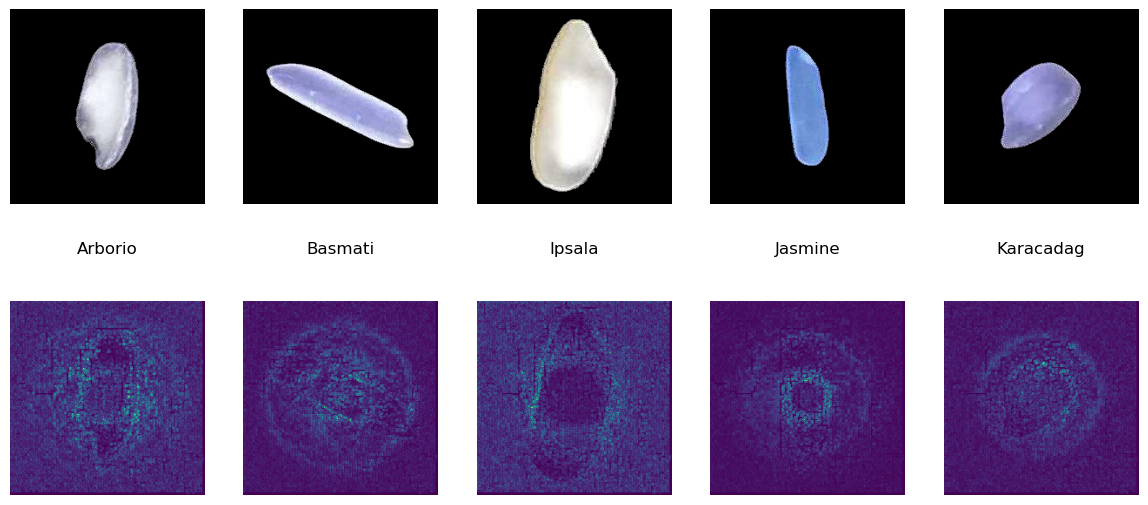

In [42]:
input_data_sample, target_sample, class_label_sample = generate_samples(dataset)
salience_map = SaliencyMap(device=device)
salience_map.show_saliency_maps(X=input_data_sample, y=target_sample, labels=class_label_sample, model=cnn_model_trained)